In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import altair as alt
import polars as pl
import pandas as pd
import sys
sys.path.append('../visualization_functions')
import altair_utils as alt_utils
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
import joypy
import glob

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate

In [4]:
def get_device_as_pl_df(device, db_con, lazy=False):
    """
    Accesses duckdb database and returns columns of interest, labeled reasonably with session identifiers cast as categoricals.
    :param device: device name (str) (e.g. '02L')
    :param db_con: duckdb connection object
    :return: polars Dataframe
    """
    db_con.sql("SET TIMEZONE = 'America/Los_Angeles'")
    if lazy:
        return db_con.sql(f"select DerivedTime, columns('localTime'), columns('^Session|TD_|Power_Band'), SleepStage from overnight.r{device}").pl().lazy().with_columns(
            pl.col('^Session.*$').cast(pl.Categorical)
        )
    else:
        return db_con.sql(f"select DerivedTime, columns('localTime'), columns('^Session|TD_|Power_Band'), SleepStage from overnight.r{device}").pl().with_columns(
            pl.col('^Session.*$').cast(pl.Categorical)
        )

In [3]:
import plotly.io as pio
alt.data_transformers.disable_max_rows()
dataspell = False
use_data_server = True # Use data server if you want to use the Vega Editor window
use_browser_for_plotly=False
remote = True

# The below commands allow for Altair to plot large data sets.

if dataspell:
    if use_data_server:
        alt.data_transformers.enable('data_server') # <- Exports to temporary localHost URL
        print('Data Server Enabled')
    else:
        vf.enable()
        print('VegaFusion Enabled')
    if use_browser_for_plotly:
        pio.renderers.default = 'browser'
    print("DataSpell Setup")
else:
    if not remote:
        # DO NOT RUN BELOW IN REMOTE VSCODE.
        if use_data_server:
            alt.data_transformers.enable('data_server') # <- Exports to temporary localHost URL
            print('Data Server Enabled')
        else:
            vf.enable_widget(data_dir='/media/shortterm_ssd/Clay/altairdata/')
            print('VegaFusion Widget Enabled')

    if use_browser_for_plotly:
        pio.renderers.default = 'browser'
        print("Plotly Browser Enabled")

    from plotly_resampler import register_plotly_resampler, unregister_plotly_resampler
    register_plotly_resampler(mode='auto')
    print("Plotly Resampler Enabled")
    print("VS Code")
'''
Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']
'''
pio.templates.default = "plotly_white"

Plotly Resampler Enabled
VS Code


In [5]:
# Import data to polars dataframes
parts = {}
charts = {}
parts_2lda = {}
parts_2dt = {}
parts_kl = {}
pattern = '/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/'

for device in ['RCS02L', 'RCS02R', 'RCS03L', 'RCS03R', 'RCS07L', 'RCS07R', 'RCS09L', 'RCS09R', 'RCS16L', 'RCS16R']:
    parts[device] = pl.read_parquet(f'/media/shortterm_ssd/Clay/databases/Sleep_10day_with_autonomic/{device}/hyperparameter_search_results_only_cortical.parquet')
    parts_2lda[device] = pl.read_parquet(f'/media/shortterm_ssd/Clay/databases/Sleep_10day_with_autonomic/{device}/hyperparameter_search_results_TwoStepLDATree_only_cortical_scoring_AUC.parquet') 
    parts_2dt[device] = pl.read_parquet(f'/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/{device}/hyperparameter_search_results_Decision_Tree_only_cortical.parquet')
    print(glob.glob(pattern + f'{device[3:]}/*/*.parquet')[0])
    parts_kl[device] = pl.read_parquet(glob.glob(pattern + f'{device[3:]}/*/*.parquet')[0])



/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/02L/2023-07-19_18-09-46_cortical_tds/powerband_search_results_2023-07-19_18-09-46.parquet
/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/02R/2023-07-19_18-09-46_cortical_tds/powerband_search_results_2023-07-19_18-09-46.parquet
/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/03L/2023-07-19_18-09-46_cortical_tds/powerband_search_results_2023-07-19_18-09-46.parquet
/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/03R/2023-07-19_18-09-46_cortical_tds/powerband_search_results_2023-07-19_18-09-46.parquet
/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/07L/2023-07-19_18-09-46_cortical_tds/powerband_search_results_2023-07-19_18-09-46.parquet
/media/longterm_hdd/Clay/Sleep_10day_with_autonomic/powerband_identification/07R/2023-07-19_18-09-46_cortical_tds/powerband_search_results_2023-07-19_18-09-46.parque

In [6]:
parts['RCS16L'].sort('AUC', descending=True).head()


shape: (5, 17)
┌────────────┬───────────┬───────────┬───────────┬───┬──────────┬──────────┬────────────┬──────────┐
│ PB1        ┆ PB2       ┆ PB3       ┆ PB4       ┆ … ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64]  ┆ list[i64] ┆ list[i64] ┆ list[i64] ┆   ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│            ┆           ┆           ┆           ┆   ┆ f64      ┆          ┆ f64        ┆          │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪══════════╪════════════╪══════════╡
│ [2, 31]    ┆ [514,     ┆ [null,    ┆ [null,    ┆ … ┆ 0.00623  ┆ 0.006504 ┆ 0.007414   ┆ 0.011751 │
│            ┆ 539]      ┆ null]     ┆ null]     ┆   ┆          ┆          ┆            ┆          │
│ [514, 520] ┆ [2, 3]    ┆ [527,     ┆ [521,     ┆ … ┆ 0.005978 ┆ 0.010223 ┆ 0.005664   ┆ 0.009021 │
│            ┆           ┆ 532]      ┆ 526]      ┆   ┆          ┆          ┆            ┆          │
│ [2, 3]     ┆ [527,     ┆ [514,     ┆ [521,     ┆ … ┆ 0.013079 ┆ 0.013216 ┆ 0.011465   ┆ 0.015149 │
│            ┆ 533]      ┆ 520]      ┆ 526]      ┆   ┆          ┆          ┆            ┆          │
│ [514, 518] ┆ [529,     ┆ [2, 3]    ┆ [524,     ┆ … ┆ 0.003207 ┆ 0.013441 ┆ 0.002621   ┆ 0.007759 │
│            ┆ 534]      ┆           ┆ 528]      ┆   ┆          ┆          ┆            ┆          │
│ [514, 518] ┆ [529,     ┆ [2, 3]    ┆ [519,     ┆ … ┆ 0.00556  ┆ 0.01394  ┆ 0.008126   ┆ 0.016464 │
│            ┆ 534]      ┆           ┆ 523]      ┆   ┆          ┆          ┆            ┆          │
└────────────┴───────────┴───────────┴───────────┴───┴──────────┴──────────┴────────────┴──────────┘

In [8]:
parts['RCS16R'].sort('AUC', descending=True).head()

shape: (5, 17)
┌───────────┬────────────┬───────────┬───────────┬───┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2        ┆ PB3       ┆ PB4       ┆ … ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---        ┆ ---       ┆ ---       ┆   ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64]  ┆ list[i64] ┆ list[i64] ┆   ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆            ┆           ┆           ┆   ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪════════════╪═══════════╪═══════════╪═══╪══════════╪══════════╪════════════╪══════════╡
│ [2, 9]    ┆ [514, 521] ┆ [19, 22]  ┆ [531,     ┆ … ┆ 0.005233 ┆ 0.00425  ┆ 0.005713   ┆ 0.00876  │
│           ┆            ┆           ┆ 533]      ┆   ┆          ┆          ┆            ┆          │
│ [2, 9]    ┆ [538, 545] ┆ [514,     ┆ [27, 32]  ┆ … ┆ 0.007111 ┆ 0.010663 ┆ 0.00716    ┆ 0.012722 │
│           ┆            ┆ 521]      ┆           ┆   ┆          ┆          ┆            ┆          │
│ [2, 9]    ┆ [531, 545] ┆ [27, 32]  ┆ [514,     ┆ … ┆ 0.005642 ┆ 0.006963 ┆ 0.007665   ┆ 0.014295 │
│           ┆            ┆           ┆ 521]      ┆   ┆          ┆          ┆            ┆          │
│ [2, 9]    ┆ [531, 545] ┆ [27, 32]  ┆ [19, 22]  ┆ … ┆ 0.003207 ┆ 0.013825 ┆ 0.008278   ┆ 0.018191 │
│ [2, 9]    ┆ [514, 521] ┆ [19, 22]  ┆ [27, 32]  ┆ … ┆ 0.004807 ┆ 0.008519 ┆ 0.004577   ┆ 0.00824  │
└───────────┴────────────┴───────────┴───────────┴───┴──────────┴──────────┴────────────┴──────────┘

In [27]:
parts_kl['RCS07L'].head()

shape: (5, 33)
┌─────────┬──────────┬──────────┬──────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ PB1_ind ┆ PB2_inde ┆ PB3_inde ┆ PB4_inde ┆ … ┆ session_ac ┆ session_AU ┆ session_re ┆ session_pr │
│ ex      ┆ x        ┆ x        ┆ x        ┆   ┆ curacy_std ┆ C_std      ┆ call_std   ┆ ecision_st │
│ ---     ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ d          │
│ list[i6 ┆ list[i64 ┆ list[i64 ┆ list[i64 ┆   ┆ f64        ┆ f64        ┆ f64        ┆ ---        │
│ 4]      ┆ ]        ┆ ]        ┆ ]        ┆   ┆            ┆            ┆            ┆ f64        │
╞═════════╪══════════╪══════════╪══════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ [514,   ┆ [2, 117] ┆ [null,   ┆ [null,   ┆ … ┆ 0.073377   ┆ 0.067738   ┆ 0.103389   ┆ 0.06557    │
│ 543]    ┆          ┆ null]    ┆ null]    ┆   ┆            ┆            ┆            ┆            │
│ [514,   ┆ [2, 31]  ┆ [108,    ┆ [null,   ┆ … ┆ 0.076161   ┆ 0.065471   ┆ 0.098471   ┆ 0.071282   │
│ 543]    ┆          ┆ 117]     ┆ null]    ┆   ┆            ┆            ┆            ┆            │
│ [514,   ┆ [18, 31] ┆ [108,    ┆ [2, 9]   ┆ … ┆ 0.079256   ┆ 0.067524   ┆ 0.099168   ┆ 0.074624   │
│ 543]    ┆          ┆ 117]     ┆          ┆   ┆            ┆            ┆            ┆            │
│ [529,   ┆ [18, 31] ┆ [108,    ┆ [2, 9]   ┆ … ┆ 0.078842   ┆ 0.070043   ┆ 0.092484   ┆ 0.077542   │
│ 543]    ┆          ┆ 117]     ┆          ┆   ┆            ┆            ┆            ┆            │
│ [529,   ┆ [18, 31] ┆ [108,    ┆ [514,    ┆ … ┆ 0.076804   ┆ 0.068801   ┆ 0.090767   ┆ 0.080372   │
│ 543]    ┆          ┆ 117]     ┆ 520]     ┆   ┆            ┆            ┆            ┆            │
└─────────┴──────────┴──────────┴──────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [142]:
import scipy.fft as fft

def index_to_frequency(index_list, sampling_rate, window_length):
    """
    Returns the corresponding frequency bin of the FFT output frequency bins
    calculated using Scipy library.
    """
    if index_list[0] >= 512:
        index_list = [i - 512 for i in index_list]
        channel = 'Channel 2'
    else:
        channel = 'Channel 1'
    nyquist_freq = sampling_rate / 2.0
    frequency_bins = fft.fftfreq(window_length, 1.0/sampling_rate)
    index_to_freq = []
    
    for index in index_list:
        freq = abs(frequency_bins[index])
        if freq > nyquist_freq:
            freq = sampling_rate - freq
        index_to_freq.append(freq)
    return {'Channel': channel, 'freq_range': index_to_freq}

In [153]:
def get_top_pb_as_freq(parts, score):
     "Returns the top powerband combinations for the given score, as frequencies."
     top_combos = {}
     for device in parts.keys():
          df_tmp = parts[device].sort(pl.col(score), descending=True).with_row_count().head(10)
          print(device)
          df_freqs = df_tmp.select(
               [pl.col(pb).apply(lambda x: index_to_frequency(x.to_list(), 500, 1024)) for pb in ['PB1', 'PB2', 'PB3', 'PB4']
               ])
          top_combos[device] = df_freqs[0,:].to_dict(as_series=False)
          print(df_freqs[0,:].to_dict(as_series=False))

RCS02L
{'PB1': [{'Channel': 'Channel 2', 'freq_range': [12.6953125, 13.671875]}], 'PB2': [{'Channel': 'Channel 1', 'freq_range': [22.4609375, 23.4375]}], 'PB3': [{'Channel': 'Channel 2', 'freq_range': [0.9765625, 3.41796875]}], 'PB4': [{'Channel': 'Channel 2', 'freq_range': [18.5546875, 21.484375]}]}
RCS02R
{'PB1': [{'Channel': 'Channel 2', 'freq_range': [9.27734375, 11.23046875]}], 'PB2': [{'Channel': 'Channel 2', 'freq_range': [20.5078125, 23.92578125]}], 'PB3': [{'Channel': 'Channel 2', 'freq_range': [0.9765625, 3.41796875]}], 'PB4': [{'Channel': 'Channel 2', 'freq_range': [13.671875, 14.6484375]}]}
RCS03L
{'PB1': [{'Channel': 'Channel 1', 'freq_range': [23.4375, 25.390625]}], 'PB2': [{'Channel': 'Channel 2', 'freq_range': [18.06640625, 19.53125]}], 'PB3': [{'Channel': 'Channel 1', 'freq_range': [0.9765625, 2.44140625]}], 'PB4': [{'Channel': 'Channel 2', 'freq_range': [24.4140625, 25.390625]}]}
RCS03R
{'PB1': [{'Channel': 'Channel 1', 'freq_range': [0.9765625, 1.953125]}], 'PB2': [{

In [6]:
# Get the scores of the canonical powerbands for each participant
con = duckdb.connect(database='/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb', read_only=True)
update_rates = [1, 5, 10, 15, 30]
devices = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
#devices = ['02L', '02R']
sleep_stage_mapping = {2: 1, 3: 1, 4: 0, 5: 0, 6: 0}
repeat_cv = False # For just calculating accuracy
np.random.seed(seed=1)

for i, device in enumerate(devices):
   print(device)
   if repeat_cv:
      scores = []
      scores_var = []
   else:
      #cv_results = {'test_tn': [], 'test_fp': [], 'test_fn': [], 'test_tp': []}
      #cv_results = {'test_accuracy': [], 'test_auc': [], 'test_balanced_accuracy': []}
      cv_results = {'test_accuracy': [], 'test_roc_auc': [], 'test_balanced_accuracy': [], 'test_recall': [], 'test_precision': []}
   df = get_device_as_pl_df(device, con)

   for update_rate in update_rates:
      data_for_baseline = (df.filter(pl.col('Power_Band8').is_not_null())
                           .with_row_count().with_columns([
                              pl.col('row_nr') // update_rate
                           ])
                           .groupby(['row_nr']).agg([
                              pl.col('Power_Band5').mean().alias('Power_Band5'),
                              pl.col('Power_Band6').mean().alias('Power_Band6'),
                              pl.col('Power_Band7').mean().alias('Power_Band7'),
                              pl.col('Power_Band8').mean().alias('Power_Band8'),
                              pl.col('SleepStage').last().alias('SleepStage'),
                              pl.col('SessionIdentity').last().alias('SessionIdentity')
                           ])
                           )
      
      if device in ['07L', '07R']:
         data_for_baseline = data_for_baseline.filter( pl.col('SessionIdentity').cast(pl.Utf8).str.contains('07-22-22|07-26-22').is_not() )

      # X = PB features
      X = data_for_baseline.select(pl.col('^Power_.*$')).to_numpy()
      # y = sleep stage labels
      y = data_for_baseline.select(
         pl.col('SleepStage').map_dict(sleep_stage_mapping)
      ).to_numpy().squeeze()
      # solver = {‘svd’, ‘lsqr’, ‘eigen’}
      model = LinearDiscriminantAnalysis(solver='svd')

      if repeat_cv:
         # define model evaluation method
         cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
         # evaluate model
         scores_tmp = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=20)
         scores.append(np.mean(scores_tmp))
         scores_var.append(np.std(scores_tmp))
      else:

         cv_results_tmp = cross_validate(model, X, y, cv=5,
                      scoring=['accuracy', 'roc_auc', 'balanced_accuracy', 'recall', 'precision'])

         [cv_results[k].extend([np.mean(v)]) for (k, v) in cv_results_tmp.items() if k in cv_results.keys()]
         
   if repeat_cv:
      if i == 0:
         df_scores = pd.DataFrame({'update_rate': update_rates, 'score': scores, 'score_std': scores_var, 'device': device})
      else:
         df_tmp = pd.DataFrame({'update_rate': update_rates, 'score': scores, 'score_std': scores_var, 'device': device})
         df_scores = pd.concat([df_scores, df_tmp])
   else:
      if i == 0:
         df_scores = pd.DataFrame({'update_rate': update_rates, **cv_results, 'device': device})
      else:
         df_tmp = pd.DataFrame({'update_rate': update_rates, **cv_results, 'device': device})
         df_scores = pd.concat([df_scores, df_tmp])

print(df_scores.head())

02L


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

02R
03L


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

03R


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

07L
07R
09L
09R
16L
16R
   update_rate  test_accuracy  test_roc_auc  test_balanced_accuracy  \
0            1       0.773142      0.855349                0.751158   
1            5       0.838891      0.910261                0.830947   
2           10       0.858863      0.928101                0.853917   
3           15       0.866814      0.935302                0.862935   
4           30       0.876324      0.943848                0.873194   

   test_recall  test_precision device  
0     0.892948        0.757571    02L  
1     0.882304        0.845492    02L  
2     0.885918        0.871833    02L  
3     0.887938        0.882300    02L  
4     0.893317        0.892933    02L  


In [7]:
df_scores.head()
# Rename Acc and AUC columns to match with those from the parts lists
df_scores_smooth = pl.from_pandas(df_scores).filter( pl.col('update_rate') == 30 )
df_scores_smooth = df_scores_smooth.rename({'test_accuracy': 'Acc', 'test_roc_auc': 'AUC'})
df_scores_smooth

shape: (10, 7)
┌─────────────┬──────────┬──────────┬──────────────────────┬─────────────┬────────────────┬────────┐
│ update_rate ┆ Acc      ┆ AUC      ┆ test_balanced_accura ┆ test_recall ┆ test_precision ┆ device │
│ ---         ┆ ---      ┆ ---      ┆ cy                   ┆ ---         ┆ ---            ┆ ---    │
│ i64         ┆ f64      ┆ f64      ┆ ---                  ┆ f64         ┆ f64            ┆ str    │
│             ┆          ┆          ┆ f64                  ┆             ┆                ┆        │
╞═════════════╪══════════╪══════════╪══════════════════════╪═════════════╪════════════════╪════════╡
│ 30          ┆ 0.876324 ┆ 0.943848 ┆ 0.873194             ┆ 0.893317    ┆ 0.892933       ┆ 02L    │
│ 30          ┆ 0.870112 ┆ 0.935407 ┆ 0.869445             ┆ 0.872818    ┆ 0.907288       ┆ 02R    │
│ 30          ┆ 0.866749 ┆ 0.935589 ┆ 0.868166             ┆ 0.847119    ┆ 0.897409       ┆ 03L    │
│ 30          ┆ 0.854381 ┆ 0.933994 ┆ 0.856274             ┆ 0.794499    ┆ 0.911441       ┆ 03R    │
│ …           ┆ …        ┆ …        ┆ …                    ┆ …           ┆ …              ┆ …      │
│ 30          ┆ 0.855798 ┆ 0.915972 ┆ 0.852027             ┆ 0.872256    ┆ 0.883587       ┆ 09L    │
│ 30          ┆ 0.795112 ┆ 0.844014 ┆ 0.787792             ┆ 0.865       ┆ 0.783427       ┆ 09R    │
│ 30          ┆ 0.791024 ┆ 0.837849 ┆ 0.786112             ┆ 0.817549    ┆ 0.820785       ┆ 16L    │
│ 30          ┆ 0.832863 ┆ 0.869734 ┆ 0.819083             ┆ 0.900681    ┆ 0.828724       ┆ 16R    │
└─────────────┴──────────┴──────────┴──────────────────────┴─────────────┴────────────────┴────────┘

In [8]:
def plot_scores(parts_dict, baselines, devices, score, plot_baselines=True, ylim=(0.8,1), linewidth=2, alpha=1):
    # Create a colormap
    colormap = plt.cm.get_cmap('jet')

    # Linearly space colors from the colormap
    colors = [colormap(i) for i in np.linspace(0, 1, len(devices))]

    for key, part in parts_dict.items():
        plt.figure()
        for device in devices:
            df_tmp = part[device].select(score).sort(pl.col(score), descending=True).with_row_count().head(10)
            df_tmp = df_tmp.with_columns(
                pl.lit(
                    baselines.filter( (pl.col('device') == device[3:]) ).select(pl.col(score)).item()
                ).alias('baseline')
            )
            df_tmp = df_tmp.to_pandas()
            sns.lineplot(data=df_tmp, x='row_nr', y=score, label=device, color=colors[devices.index(device)], linewidth=linewidth, alpha=alpha)
            if plot_baselines:
                sns.lineplot(data=df_tmp, x='row_nr', y='baseline', linestyle=':', color=colors[devices.index(device)], linewidth=linewidth, alpha=alpha)
            plt.ylim(*ylim)
            plt.legend(loc='lower right')
            plt.title(f'{key} {score} by PB Combination for Cortex')
        plt.show()

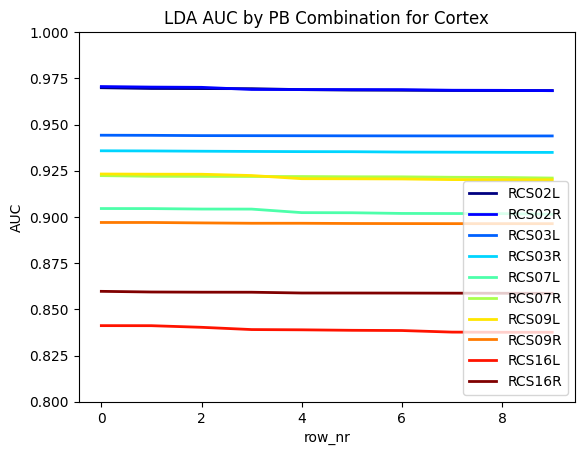

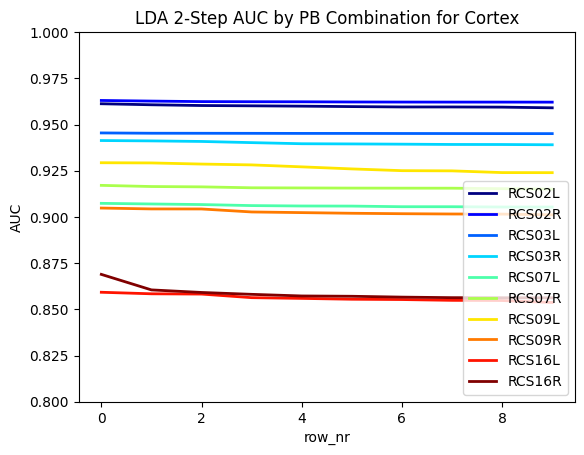

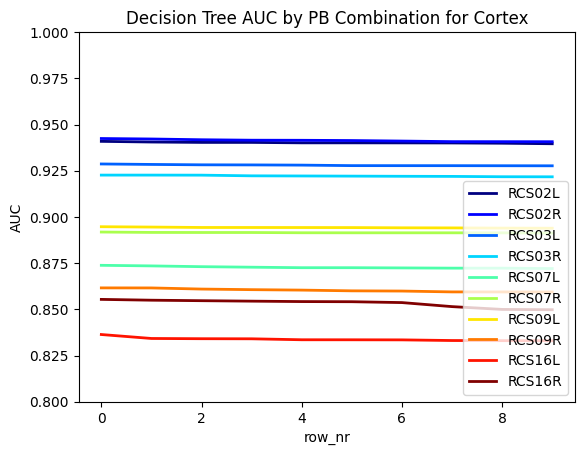

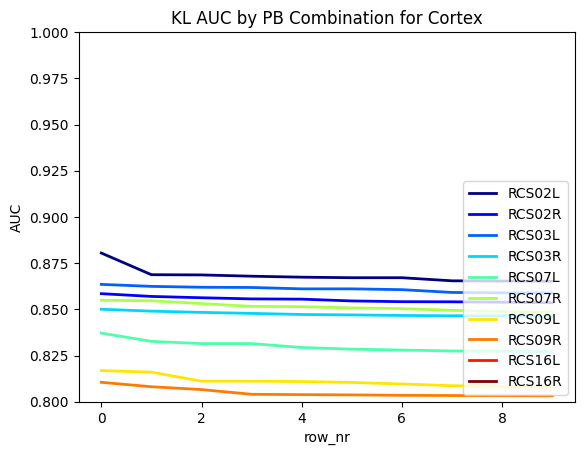

In [11]:
devices = ['RCS' + ele for ele in ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']]
parts_dict = {'LDA': parts, 'LDA 2-Step': parts_2lda, 'Decision Tree': parts_2dt, 'KL': parts_kl}
plot_scores(parts_dict, df_scores_smooth, devices, 'AUC', plot_baselines=False, ylim=(.8,1))

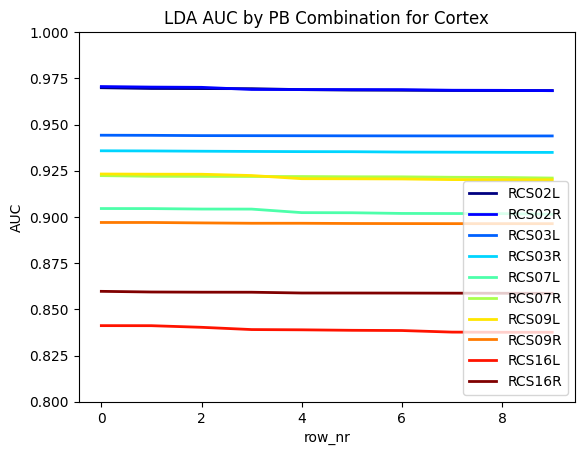

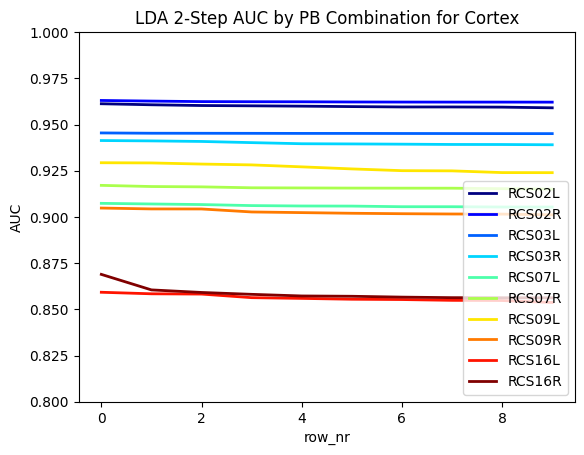

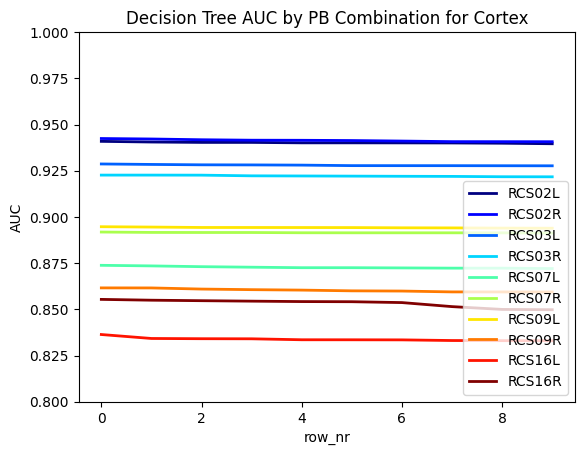

In [127]:
devices = ['RCS' + ele for ele in ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']]
parts_dict = {'LDA': parts, 'LDA 2-Step': parts_2lda, 'Decision Tree': parts_2dt}
plot_scores(parts_dict, df_scores_smooth, devices, 'AUC', plot_baselines=False)

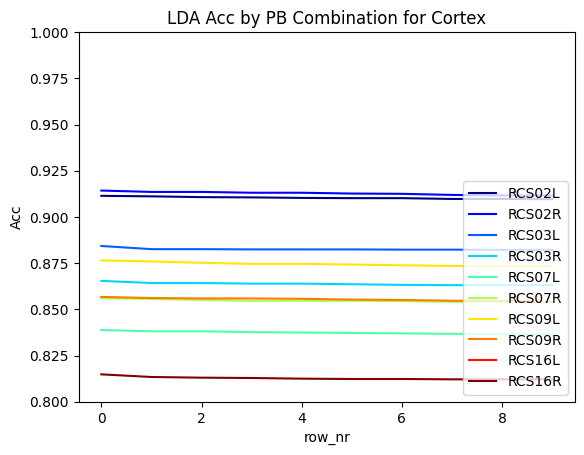

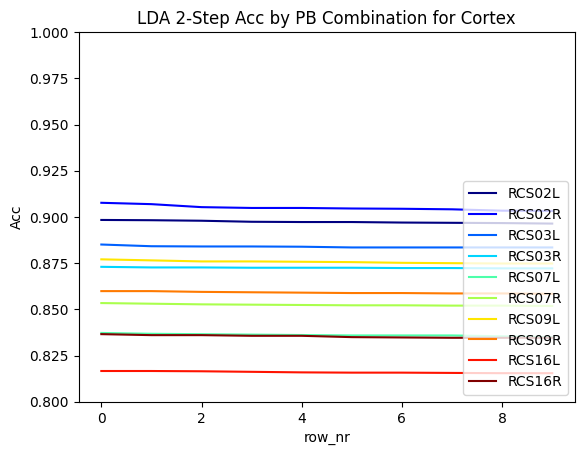

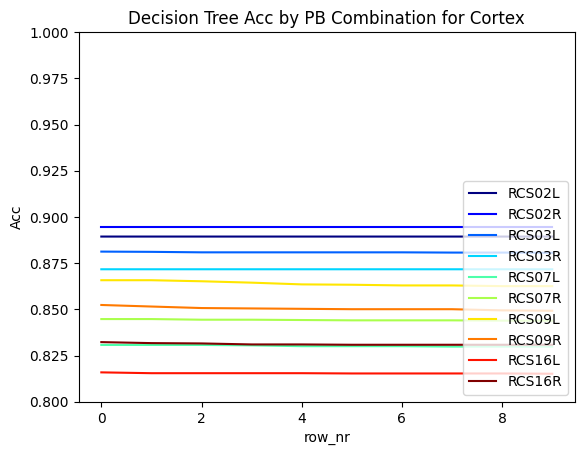

In [94]:
plot_scores(parts_dict, df_scores_smooth, devices, 'Acc', plot_baselines=False)

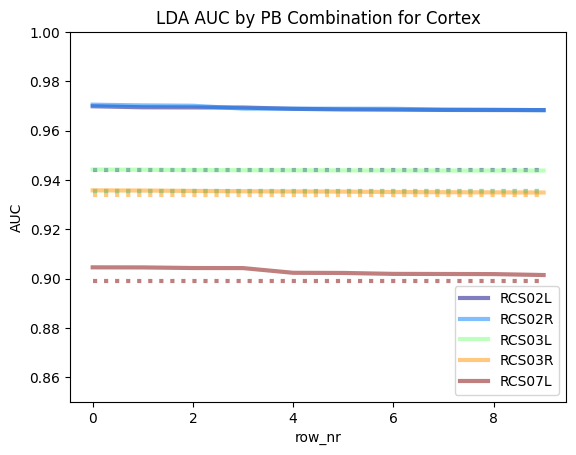

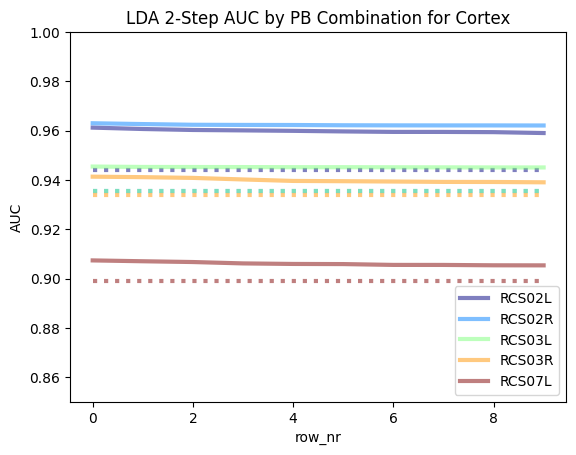

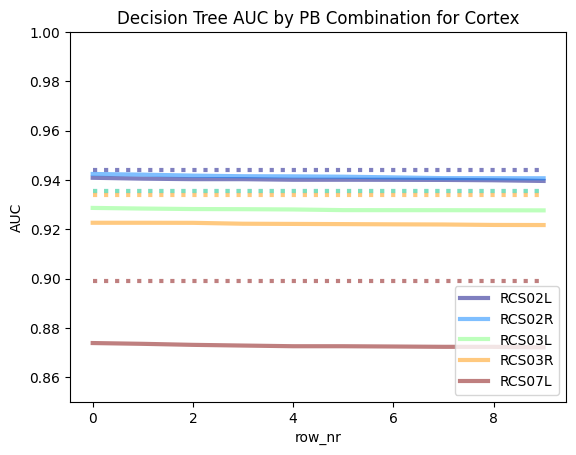

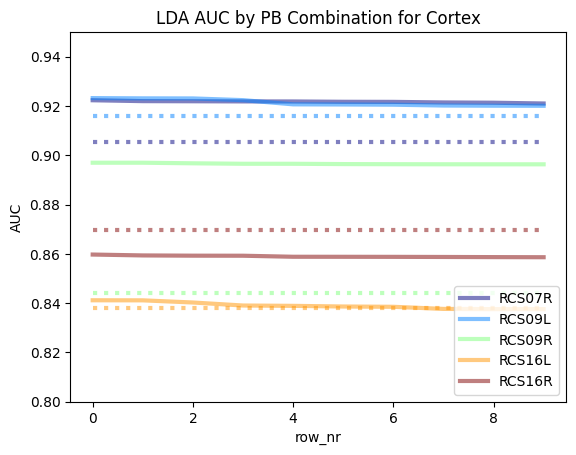

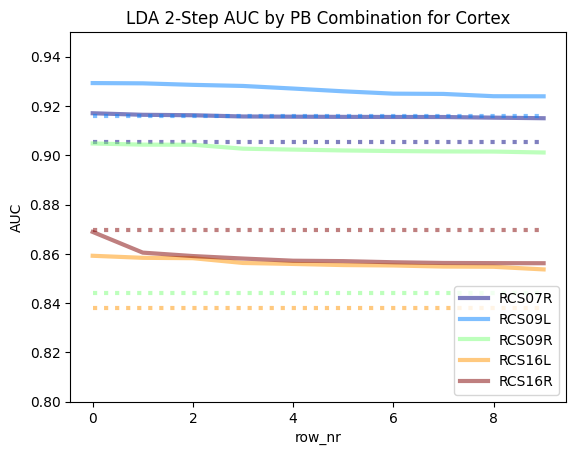

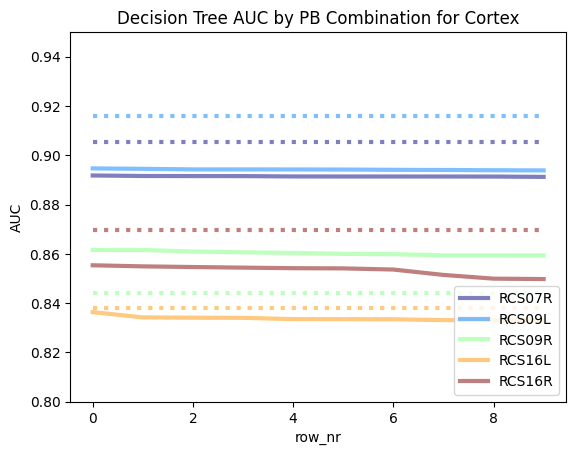

In [135]:
plot_scores(parts_dict, df_scores_smooth, devices[:5], 'AUC', plot_baselines=True, ylim=(0.85,1), linewidth=3, alpha=0.5)
plot_scores(parts_dict, df_scores_smooth, devices[5:], 'AUC', plot_baselines=True, ylim=(0.8,0.95), linewidth=3, alpha=0.5)

In [13]:
# Find channels that can feasibly be embedded onto device

num = 5
for key in parts.keys():
    print(key)
    display(parts[key].filter(
                             pl.col('PB1').arr.concat(['PB2', 'PB3', 'PB4']).arr.eval(pl.element() > 511).arr.sum() == 4
    ).sort('AUC', descending=True).head(num))

02L


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [39, 52]  ┆ [84, 102] ┆ [555,     ┆ [516,    ┆ ... ┆ 0.000796 ┆ 0.004213 ┆ 0.003555   ┆ 0.005569 │
│           ┆           ┆ 566]      ┆ 520]     ┆     ┆          ┆          ┆            ┆          │
│ [3, 6]    ┆ [84, 102] ┆ [555,     ┆ [516,    ┆ ... ┆ 0.005624 ┆ 0.011663 ┆ 0.003507   ┆ 0.005198 │
│           ┆           ┆ 566]      ┆ 520]     ┆     ┆          ┆          ┆            ┆          │
│ [39, 52]  ┆ [555,     ┆ [516,     ┆ [100,    ┆ ... ┆ 0.006093 ┆ 0.004202 ┆ 0.006469   ┆ 0.009144 │
│           ┆ 566]      ┆ 520]      ┆ 109]     ┆     ┆          ┆          ┆            ┆          │
│ [84, 96]  ┆ [555,     ┆ [516,     ┆ [100,    ┆ ... ┆ 0.003773 ┆ 0.006333 ┆ 0.006422   ┆ 0.01023  │
│           ┆ 566]      ┆ 520]      ┆ 109]     ┆     ┆          ┆          ┆            ┆          │
│ [105,     ┆ [84, 102] ┆ [555,     ┆ [516,    ┆ ... ┆ 0.005292 ┆ 0.007512 ┆ 0.007431   ┆ 0.011246 │
│ 118]      ┆           ┆ 566]      ┆ 520]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

02L_2LDA


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [2, 6]    ┆ [538,     ┆ [46, 48]  ┆ [514,    ┆ ... ┆ 0.006966 ┆ 0.00679  ┆ 0.005677   ┆ 0.007925 │
│           ┆ 540]      ┆           ┆ 519]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 6]    ┆ [538,     ┆ [46, 48]  ┆ [550,    ┆ ... ┆ 0.008005 ┆ 0.008783 ┆ 0.009906   ┆ 0.01475  │
│           ┆ 540]      ┆           ┆ 556]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 6]    ┆ [538,     ┆ [46, 48]  ┆ [557,    ┆ ... ┆ 0.004208 ┆ 0.005168 ┆ 0.00799    ┆ 0.012304 │
│           ┆ 540]      ┆           ┆ 561]     ┆     ┆          ┆          ┆            ┆          │
│ [538,     ┆ [46, 48]  ┆ [514,     ┆ [7, 14]  ┆ ... ┆ 0.005446 ┆ 0.00924  ┆ 0.007454   ┆ 0.011906 │
│ 540]      ┆           ┆ 519]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [46, 48]  ┆ [532,     ┆ [556,     ┆ [7, 14]  ┆ ... ┆ 0.003449 ┆ 0.006335 ┆ 0.006211   ┆ 0.009049 │
│           ┆ 540]      ┆ 561]      ┆          ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

02R


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [98, 119] ┆ [36, 54]  ┆ [514,     ┆ [531,    ┆ ... ┆ 0.004653 ┆ 0.0032   ┆ 0.006048   ┆ 0.00924  │
│           ┆           ┆ 519]      ┆ 541]     ┆     ┆          ┆          ┆            ┆          │
│ [531,     ┆ [36, 54]  ┆ [514,     ┆ [98,     ┆ ... ┆ 0.005632 ┆ 0.007737 ┆ 0.003419   ┆ 0.004728 │
│ 541]      ┆           ┆ 519]      ┆ 108]     ┆     ┆          ┆          ┆            ┆          │
│ [531,     ┆ [112,     ┆ [36, 54]  ┆ [514,    ┆ ... ┆ 0.011296 ┆ 0.014106 ┆ 0.009802   ┆ 0.01426  │
│ 541]      ┆ 119]      ┆           ┆ 519]     ┆     ┆          ┆          ┆            ┆          │
│ [548,     ┆ [98, 119] ┆ [36, 54]  ┆ [531,    ┆ ... ┆ 0.004555 ┆ 0.006031 ┆ 0.003851   ┆ 0.005849 │
│ 563]      ┆           ┆           ┆ 541]     ┆     ┆          ┆          ┆            ┆          │
│ [548,     ┆ [98, 119] ┆ [36, 54]  ┆ [514,    ┆ ... ┆ 0.00753  ┆ 0.012465 ┆ 0.002891   ┆ 0.003596 │
│ 563]      ┆           ┆           ┆ 519]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

02R_2LDA


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [2, 7]    ┆ [531,     ┆ [42, 47]  ┆ [540,    ┆ ... ┆ 0.005016 ┆ 0.014559 ┆ 0.00821    ┆ 0.014834 │
│           ┆ 535]      ┆           ┆ 542]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 7]    ┆ [42, 47]  ┆ [514,     ┆ [540,    ┆ ... ┆ 0.00719  ┆ 0.014485 ┆ 0.011224   ┆ 0.019398 │
│           ┆           ┆ 519]      ┆ 542]     ┆     ┆          ┆          ┆            ┆          │
│ [42, 47]  ┆ [514,     ┆ [20, 20]  ┆ [540,    ┆ ... ┆ 0.009766 ┆ 0.010903 ┆ 0.006256   ┆ 0.008792 │
│           ┆ 519]      ┆           ┆ 542]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 7]    ┆ [42, 47]  ┆ [514,     ┆ [540,    ┆ ... ┆ 0.011363 ┆ 0.016509 ┆ 0.006901   ┆ 0.010223 │
│           ┆           ┆ 519]      ┆ 542]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 7]    ┆ [531,     ┆ [42, 47]  ┆ [540,    ┆ ... ┆ 0.005485 ┆ 0.005065 ┆ 0.007487   ┆ 0.012744 │
│           ┆ 535]      ┆           ┆ 542]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

03L


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [554,     ┆ [514,     ┆ [2, 6]    ┆ [46, 49] ┆ ... ┆ 0.006393 ┆ 0.015695 ┆ 0.014997   ┆ 0.020245 │
│ 557]      ┆ 518]      ┆           ┆          ┆     ┆          ┆          ┆            ┆          │
│ [47, 50]  ┆ [554,     ┆ [2, 6]    ┆ [514,    ┆ ... ┆ 0.005247 ┆ 0.008342 ┆ 0.005966   ┆ 0.007636 │
│           ┆ 559]      ┆           ┆ 518]     ┆     ┆          ┆          ┆            ┆          │
│ [47, 50]  ┆ [2, 6]    ┆ [514,     ┆ [560,    ┆ ... ┆ 0.004651 ┆ 0.009603 ┆ 0.005423   ┆ 0.007256 │
│           ┆           ┆ 518]      ┆ 565]     ┆     ┆          ┆          ┆            ┆          │
│ [47, 50]  ┆ [554,     ┆ [2, 6]    ┆ [560,    ┆ ... ┆ 0.008034 ┆ 0.008643 ┆ 0.008446   ┆ 0.010059 │
│           ┆ 559]      ┆           ┆ 565]     ┆     ┆          ┆          ┆            ┆          │
│ [514,     ┆ [2, 6]    ┆ [46, 49]  ┆ [558,    ┆ ... ┆ 0.005934 ┆ 0.006695 ┆ 0.008708   ┆ 0.011288 │
│ 518]      ┆           ┆           ┆ 561]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

03L_2LDA


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [48, 52]  ┆ [549,     ┆ [2, 5]    ┆ [562,    ┆ ... ┆ 0.00853  ┆ 0.009945 ┆ 0.009332   ┆ 0.012676 │
│           ┆ 552]      ┆           ┆ 564]     ┆     ┆          ┆          ┆            ┆          │
│ [554,     ┆ [2, 5]    ┆ [549,     ┆ [48, 52] ┆ ... ┆ 0.006209 ┆ 0.005764 ┆ 0.006266   ┆ 0.008537 │
│ 558]      ┆           ┆ 553]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [48, 52]  ┆ [549,     ┆ [2, 5]    ┆ [553,    ┆ ... ┆ 0.005888 ┆ 0.002762 ┆ 0.009088   ┆ 0.013278 │
│           ┆ 552]      ┆           ┆ 557]     ┆     ┆          ┆          ┆            ┆          │
│ [48, 52]  ┆ [549,     ┆ [2, 5]    ┆ [558,    ┆ ... ┆ 0.003598 ┆ 0.010183 ┆ 0.006289   ┆ 0.010127 │
│           ┆ 552]      ┆           ┆ 561]     ┆     ┆          ┆          ┆            ┆          │
│ [48, 52]  ┆ [549,     ┆ [2, 5]    ┆ [514,    ┆ ... ┆ 0.005735 ┆ 0.005559 ┆ 0.006785   ┆ 0.009416 │
│           ┆ 552]      ┆           ┆ 518]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

03R


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [523,     ┆ [45, 55]  ┆ [2, 12]   ┆ [514,    ┆ ... ┆ 0.003689 ┆ 0.007829 ┆ 0.006757   ┆ 0.007757 │
│ 535]      ┆           ┆           ┆ 521]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 5]    ┆ [535,     ┆ [514,     ┆ [51, 55] ┆ ... ┆ 0.007021 ┆ 0.007586 ┆ 0.011416   ┆ 0.01166  │
│           ┆ 535]      ┆ 519]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [2, 5]    ┆ [6, 12]   ┆ [535,     ┆ [514,    ┆ ... ┆ 0.006079 ┆ 0.011087 ┆ 0.004213   ┆ 0.004066 │
│           ┆           ┆ 535]      ┆ 519]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 5]    ┆ [535,     ┆ [6, 12]   ┆ [514,    ┆ ... ┆ 0.003462 ┆ 0.003996 ┆ 0.007569   ┆ 0.008015 │
│           ┆ 535]      ┆           ┆ 519]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 5]    ┆ [520,     ┆ [535,     ┆ [51, 55] ┆ ... ┆ 0.005433 ┆ 0.006909 ┆ 0.006346   ┆ 0.006311 │
│           ┆ 526]      ┆ 535]      ┆          ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

03R_2LDA


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [2, 4]    ┆ [42, 59]  ┆ [606,     ┆ [572,    ┆ ... ┆ 0.008498 ┆ 0.007801 ┆ 0.009719   ┆ 0.011369 │
│           ┆           ┆ 611]      ┆ 580]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 4]    ┆ [606,     ┆ [17, 19]  ┆ [572,    ┆ ... ┆ 0.007001 ┆ 0.009329 ┆ 0.010449   ┆ 0.013097 │
│           ┆ 611]      ┆           ┆ 580]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 4]    ┆ [559,     ┆ [42, 59]  ┆ [606,    ┆ ... ┆ 0.006629 ┆ 0.006277 ┆ 0.009498   ┆ 0.011492 │
│           ┆ 566]      ┆           ┆ 611]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 4]    ┆ [559,     ┆ [98, 98]  ┆ [572,    ┆ ... ┆ 0.00845  ┆ 0.004943 ┆ 0.015749   ┆ 0.020268 │
│           ┆ 566]      ┆           ┆ 580]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 4]    ┆ [606,     ┆ [98, 98]  ┆ [572,    ┆ ... ┆ 0.00895  ┆ 0.005745 ┆ 0.015076   ┆ 0.018827 │
│           ┆ 611]      ┆           ┆ 580]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

07L


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [88, 103] ┆ [515,     ┆ [42, 58]  ┆ [563,    ┆ ... ┆ 0.00529  ┆ 0.007556 ┆ 0.00592    ┆ 0.008361 │
│           ┆ 540]      ┆           ┆ 582]     ┆     ┆          ┆          ┆            ┆          │
│ [88, 103] ┆ [515,     ┆ [2, 28]   ┆ [563,    ┆ ... ┆ 0.004965 ┆ 0.008469 ┆ 0.003254   ┆ 0.00421  │
│           ┆ 540]      ┆           ┆ 582]     ┆     ┆          ┆          ┆            ┆          │
│ [563,     ┆ [88, 103] ┆ [515,     ┆ [28, 28] ┆ ... ┆ 0.003073 ┆ 0.010785 ┆ 0.005577   ┆ 0.009594 │
│ 571]      ┆           ┆ 521]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [515,     ┆ [2, 28]   ┆ [42, 58]  ┆ [563,    ┆ ... ┆ 0.006123 ┆ 0.00807  ┆ 0.009575   ┆ 0.013614 │
│ 540]      ┆           ┆           ┆ 582]     ┆     ┆          ┆          ┆            ┆          │
│ [515,     ┆ [42, 58]  ┆ [28, 28]  ┆ [532,    ┆ ... ┆ 0.007421 ┆ 0.009479 ┆ 0.007773   ┆ 0.011039 │
│ 521]      ┆           ┆           ┆ 540]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

07L_2LDA


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [44, 57]  ┆ [515,     ┆ [614,     ┆ [28, 28] ┆ ... ┆ 0.005683 ┆ 0.013125 ┆ 0.003831   ┆ 0.00681  │
│           ┆ 521]      ┆ 618]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [515,     ┆ [44, 57]  ┆ [614,     ┆ [2, 28]  ┆ ... ┆ 0.004169 ┆ 0.005779 ┆ 0.006134   ┆ 0.010585 │
│ 521]      ┆           ┆ 618]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [87, 105] ┆ [561,     ┆ [515,     ┆ [28, 28] ┆ ... ┆ 0.007971 ┆ 0.009033 ┆ 0.006119   ┆ 0.008068 │
│           ┆ 581]      ┆ 521]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [515,     ┆ [561,     ┆ [87, 105] ┆ [2, 28]  ┆ ... ┆ 0.010928 ┆ 0.017143 ┆ 0.008111   ┆ 0.010945 │
│ 521]      ┆ 581]      ┆           ┆          ┆     ┆          ┆          ┆            ┆          │
│ [2, 28]   ┆ [515,     ┆ [44, 57]  ┆ [614,    ┆ ... ┆ 0.013421 ┆ 0.006535 ┆ 0.015389   ┆ 0.02228  │
│           ┆ 540]      ┆           ┆ 618]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

07R


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [556,     ┆ [2, 63]   ┆ [88, 108] ┆ [515,    ┆ ... ┆ 0.007408 ┆ 0.011033 ┆ 0.012312   ┆ 0.0181   │
│ 584]      ┆           ┆           ┆ 531]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 29]   ┆ [556,     ┆ [88, 108] ┆ [515,    ┆ ... ┆ 0.017181 ┆ 0.018398 ┆ 0.017225   ┆ 0.02161  │
│           ┆ 584]      ┆           ┆ 531]     ┆     ┆          ┆          ┆            ┆          │
│ [88, 108] ┆ [515,     ┆ [556,     ┆ [2, 29]  ┆ ... ┆ 0.00208  ┆ 0.006868 ┆ 0.00645    ┆ 0.010017 │
│           ┆ 531]      ┆ 571]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [556,     ┆ [88, 108] ┆ [515,     ┆ [24, 29] ┆ ... ┆ 0.010857 ┆ 0.012094 ┆ 0.009574   ┆ 0.011381 │
│ 571]      ┆           ┆ 531]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [515,     ┆ [24, 29]  ┆ [556,     ┆ [100,    ┆ ... ┆ 0.006006 ┆ 0.004455 ┆ 0.006264   ┆ 0.007736 │
│ 531]      ┆           ┆ 571]      ┆ 108]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

07R_2LDA


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [24, 30]  ┆ [522,     ┆ [38, 51]  ┆ [514,    ┆ ... ┆ 0.005666 ┆ 0.008491 ┆ 0.005032   ┆ 0.006949 │
│           ┆ 531]      ┆           ┆ 520]     ┆     ┆          ┆          ┆            ┆          │
│ [45, 51]  ┆ [522,     ┆ [24, 30]  ┆ [514,    ┆ ... ┆ 0.011053 ┆ 0.006739 ┆ 0.013489   ┆ 0.018643 │
│           ┆ 531]      ┆           ┆ 520]     ┆     ┆          ┆          ┆            ┆          │
│ [514,     ┆ [38, 46]  ┆ [24, 30]  ┆ [522,    ┆ ... ┆ 0.036277 ┆ 0.062522 ┆ 0.034552   ┆ 0.046413 │
│ 520]      ┆           ┆           ┆ 531]     ┆     ┆          ┆          ┆            ┆          │
│ [514,     ┆ [24, 30]  ┆ [522,     ┆ [48, 55] ┆ ... ┆ 0.004781 ┆ 0.006543 ┆ 0.009173   ┆ 0.014358 │
│ 520]      ┆           ┆ 531]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [522,     ┆ [24, 30]  ┆ [514,     ┆ [38, 43] ┆ ... ┆ 0.005639 ┆ 0.010232 ┆ 0.006568   ┆ 0.009871 │
│ 531]      ┆           ┆ 520]      ┆          ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

09L


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [27, 30]  ┆ [514,     ┆ [563,     ┆ [2, 3]   ┆ ... ┆ 0.007601 ┆ 0.01233  ┆ 0.007079   ┆ 0.009612 │
│           ┆ 537]      ┆ 564]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [514,     ┆ [2, 3]    ┆ [563,     ┆ [27, 30] ┆ ... ┆ 0.013629 ┆ 0.0138   ┆ 0.013112   ┆ 0.016889 │
│ 537]      ┆           ┆ 564]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [27, 30]  ┆ [607,     ┆ [563,     ┆ [2, 3]   ┆ ... ┆ 0.003652 ┆ 0.006665 ┆ 0.005569   ┆ 0.008585 │
│           ┆ 607]      ┆ 564]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [607,     ┆ [2, 3]    ┆ [563,     ┆ [27, 30] ┆ ... ┆ 0.002555 ┆ 0.005421 ┆ 0.002541   ┆ 0.003901 │
│ 607]      ┆           ┆ 564]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [607,     ┆ [514,     ┆ [2, 3]    ┆ [27, 30] ┆ ... ┆ 0.007394 ┆ 0.027791 ┆ 0.01225    ┆ 0.021328 │
│ 607]      ┆ 537]      ┆           ┆          ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

09L_2LDA


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [42, 54]  ┆ [514,     ┆ [595,     ┆ [26, 29] ┆ ... ┆ 0.007505 ┆ 0.012245 ┆ 0.007169   ┆ 0.010309 │
│           ┆ 526]      ┆ 611]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [42, 54]  ┆ [547,     ┆ [595,     ┆ [26, 29] ┆ ... ┆ 0.009404 ┆ 0.015058 ┆ 0.005735   ┆ 0.006722 │
│           ┆ 577]      ┆ 611]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [514,     ┆ [2, 4]    ┆ [595,     ┆ [26, 29] ┆ ... ┆ 0.009026 ┆ 0.027308 ┆ 0.012028   ┆ 0.020547 │
│ 526]      ┆           ┆ 611]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [42, 54]  ┆ [547,     ┆ [514,     ┆ [26, 29] ┆ ... ┆ 0.007072 ┆ 0.00756  ┆ 0.008901   ┆ 0.012408 │
│           ┆ 577]      ┆ 526]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [547,     ┆ [595,     ┆ [26, 29]  ┆ [58, 69] ┆ ... ┆ 0.012251 ┆ 0.018586 ┆ 0.007996   ┆ 0.009447 │
│ 577]      ┆ 611]      ┆           ┆          ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

09R


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [538,     ┆ [597,     ┆ [25, 28]  ┆ [2, 3]   ┆ ... ┆ 0.012049 ┆ 0.007046 ┆ 0.012501   ┆ 0.017661 │
│ 541]      ┆ 604]      ┆           ┆          ┆     ┆          ┆          ┆            ┆          │
│ [538,     ┆ [85, 99]  ┆ [2, 3]    ┆ [571,    ┆ ... ┆ 0.003731 ┆ 0.021702 ┆ 0.008826   ┆ 0.017328 │
│ 541]      ┆           ┆           ┆ 571]     ┆     ┆          ┆          ┆            ┆          │
│ [597,     ┆ [25, 28]  ┆ [2, 3]    ┆ [571,    ┆ ... ┆ 0.008374 ┆ 0.00612  ┆ 0.009337   ┆ 0.013441 │
│ 604]      ┆           ┆           ┆ 571]     ┆     ┆          ┆          ┆            ┆          │
│ [538,     ┆ [597,     ┆ [85, 99]  ┆ [2, 3]   ┆ ... ┆ 0.008359 ┆ 0.013134 ┆ 0.006531   ┆ 0.009348 │
│ 541]      ┆ 604]      ┆           ┆          ┆     ┆          ┆          ┆            ┆          │
│ [85, 99]  ┆ [538,     ┆ [2, 3]    ┆ [514,    ┆ ... ┆ 0.005422 ┆ 0.008371 ┆ 0.003911   ┆ 0.005086 │
│           ┆ 541]      ┆           ┆ 515]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

09R_2LDA


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [2, 3]    ┆ [43, 61]  ┆ [598,     ┆ [538,    ┆ ... ┆ 0.007391 ┆ 0.00972  ┆ 0.00646    ┆ 0.008358 │
│           ┆           ┆ 602]      ┆ 540]     ┆     ┆          ┆          ┆            ┆          │
│ [85, 102] ┆ [43, 61]  ┆ [514,     ┆ [538,    ┆ ... ┆ 0.010947 ┆ 0.016861 ┆ 0.008391   ┆ 0.011702 │
│           ┆           ┆ 515]      ┆ 540]     ┆     ┆          ┆          ┆            ┆          │
│ [43, 61]  ┆ [598,     ┆ [22, 29]  ┆ [538,    ┆ ... ┆ 0.005015 ┆ 0.007381 ┆ 0.005249   ┆ 0.008614 │
│           ┆ 602]      ┆           ┆ 540]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 3]    ┆ [564,     ┆ [85, 102] ┆ [538,    ┆ ... ┆ 0.008796 ┆ 0.019694 ┆ 0.002357   ┆ 0.004037 │
│           ┆ 564]      ┆           ┆ 540]     ┆     ┆          ┆          ┆            ┆          │
│ [85, 102] ┆ [43, 61]  ┆ [598,     ┆ [538,    ┆ ... ┆ 0.005721 ┆ 0.012006 ┆ 0.005362   ┆ 0.009717 │
│           ┆           ┆ 602]      ┆ 540]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

16L


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [23, 25]  ┆ [533,     ┆ [2, 3]    ┆ [527,    ┆ ... ┆ 0.009321 ┆ 0.01419  ┆ 0.007571   ┆ 0.011255 │
│           ┆ 539]      ┆           ┆ 532]     ┆     ┆          ┆          ┆            ┆          │
│ [514,     ┆ [23, 25]  ┆ [2, 3]    ┆ [527,    ┆ ... ┆ 0.009651 ┆ 0.00792  ┆ 0.009092   ┆ 0.013244 │
│ 520]      ┆           ┆           ┆ 532]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 3]    ┆ [527,     ┆ [23, 31]  ┆ [534,    ┆ ... ┆ 0.007877 ┆ 0.003553 ┆ 0.009317   ┆ 0.015301 │
│           ┆ 533]      ┆           ┆ 539]     ┆     ┆          ┆          ┆            ┆          │
│ [529,     ┆ [2, 3]    ┆ [535,     ┆ [23, 25] ┆ ... ┆ 0.006673 ┆ 0.006403 ┆ 0.007518   ┆ 0.011852 │
│ 534]      ┆           ┆ 539]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [514,     ┆ [2, 3]    ┆ [527,     ┆ [28, 31] ┆ ... ┆ 0.007642 ┆ 0.005906 ┆ 0.01129    ┆ 0.020318 │
│ 520]      ┆           ┆ 532]      ┆          ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

16L_2LDA


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [2, 6]    ┆ [533,     ┆ [518,     ┆ [25, 27] ┆ ... ┆ 0.01057  ┆ 0.011207 ┆ 0.008056   ┆ 0.010343 │
│           ┆ 536]      ┆ 522]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [2, 6]    ┆ [514,     ┆ [518,     ┆ [25, 27] ┆ ... ┆ 0.007914 ┆ 0.005012 ┆ 0.008782   ┆ 0.014181 │
│           ┆ 517]      ┆ 522]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [523,     ┆ [2, 6]    ┆ [518,     ┆ [25, 27] ┆ ... ┆ 0.004753 ┆ 0.008748 ┆ 0.004737   ┆ 0.008582 │
│ 527]      ┆           ┆ 522]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [21, 24]  ┆ [514,     ┆ [518,     ┆ [25, 27] ┆ ... ┆ 0.007833 ┆ 0.006778 ┆ 0.007396   ┆ 0.011384 │
│           ┆ 517]      ┆ 522]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [21, 24]  ┆ [533,     ┆ [518,     ┆ [25, 27] ┆ ... ┆ 0.00622  ┆ 0.004813 ┆ 0.006718   ┆ 0.011191 │
│           ┆ 536]      ┆ 522]      ┆          ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

16R


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [2, 9]    ┆ [514,     ┆ [19, 22]  ┆ [531,    ┆ ... ┆ 0.005233 ┆ 0.00425  ┆ 0.005713   ┆ 0.00876  │
│           ┆ 521]      ┆           ┆ 533]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 9]    ┆ [538,     ┆ [514,     ┆ [27, 32] ┆ ... ┆ 0.007111 ┆ 0.010663 ┆ 0.00716    ┆ 0.012722 │
│           ┆ 545]      ┆ 521]      ┆          ┆     ┆          ┆          ┆            ┆          │
│ [2, 9]    ┆ [531,     ┆ [27, 32]  ┆ [514,    ┆ ... ┆ 0.005642 ┆ 0.006963 ┆ 0.007665   ┆ 0.014295 │
│           ┆ 545]      ┆           ┆ 521]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 9]    ┆ [538,     ┆ [27, 32]  ┆ [531,    ┆ ... ┆ 0.012244 ┆ 0.012467 ┆ 0.012699   ┆ 0.021834 │
│           ┆ 545]      ┆           ┆ 533]     ┆     ┆          ┆          ┆            ┆          │
│ [2, 5]    ┆ [538,     ┆ [27, 32]  ┆ [531,    ┆ ... ┆ 0.00848  ┆ 0.012703 ┆ 0.010523   ┆ 0.019545 │
│           ┆ 541]      ┆           ┆ 533]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

16R_2LDA


shape: (5, 17)
┌───────────┬───────────┬───────────┬──────────┬─────┬──────────┬──────────┬────────────┬──────────┐
│ PB1       ┆ PB2       ┆ PB3       ┆ PB4      ┆ ... ┆ BalAcc_s ┆ TPR_std  ┆ precision_ ┆ TNR_std  │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆     ┆ td       ┆ ---      ┆ std        ┆ ---      │
│ list[i64] ┆ list[i64] ┆ list[i64] ┆ list[i64 ┆     ┆ ---      ┆ f64      ┆ ---        ┆ f64      │
│           ┆           ┆           ┆ ]        ┆     ┆ f64      ┆          ┆ f64        ┆          │
╞═══════════╪═══════════╪═══════════╪══════════╪═════╪══════════╪══════════╪════════════╪══════════╡
│ [7, 11]   ┆ [20, 27]  ┆ [526,     ┆ [514,    ┆ ... ┆ 0.011615 ┆ 0.059005 ┆ 0.022743   ┆ 0.05722  │
│           ┆           ┆ 533]      ┆ 518]     ┆     ┆          ┆          ┆            ┆          │
│ [514,     ┆ [3, 9]    ┆ [27, 27]  ┆ [519,    ┆ ... ┆ 0.008032 ┆ 0.005717 ┆ 0.006667   ┆ 0.012001 │
│ 518]      ┆           ┆           ┆ 523]     ┆     ┆          ┆          ┆            ┆          │
│ [3, 9]    ┆ [27, 27]  ┆ [525,     ┆ [519,    ┆ ... ┆ 0.015783 ┆ 0.062417 ┆ 0.025859   ┆ 0.063544 │
│           ┆           ┆ 529]      ┆ 523]     ┆     ┆          ┆          ┆            ┆          │
│ [530,     ┆ [3, 9]    ┆ [20, 22]  ┆ [519,    ┆ ... ┆ 0.012767 ┆ 0.008427 ┆ 0.010632   ┆ 0.018416 │
│ 533]      ┆           ┆           ┆ 523]     ┆     ┆          ┆          ┆            ┆          │
│ [530,     ┆ [3, 9]    ┆ [27, 27]  ┆ [519,    ┆ ... ┆ 0.009584 ┆ 0.008688 ┆ 0.009704   ┆ 0.019813 │
│ 533]      ┆           ┆           ┆ 523]     ┆     ┆          ┆          ┆            ┆          │
└───────────┴───────────┴───────────┴──────────┴─────┴──────────┴──────────┴────────────┴──────────┘

## Plot sorted scores via Altair


In [7]:

# graphs = ['Acc', 'AUC', 'BalAcc', 'TPR', 'precision', 'TNR']
graphs = ['AUC']
for key, part in parts.items():
    chart=alt.vconcat()
    for i, col in enumerate(graphs):
        df = part.sort(col, descending=True).with_row_count().head().to_pandas()
        chart_tmp, df = alt_utils.create_overlaid_line_plot(df, ['row_nr'], ['Acc', 'AUC'], width=500, height=300, color_scheme='category10', interactive=True)
        chart &= chart_tmp
    chart.display()
    charts[key] = chart

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [8]:
for key, chart in charts.items():
    chart = chart.configure_legend(
        labelFontSize=30,
        titleFontSize=20,
        symbolSize=500
    ).properties(
        title={
            "text": key,
            "fontSize": 25,
            "fontWeight": "bold",
            "anchor": "middle"
        }
    )
    display(chart)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [8]:

# graphs = ['Acc', 'AUC', 'BalAcc', 'TPR', 'precision', 'TNR']
graphs = ['AUC']
for key, part in parts_2.items():
    chart=alt.vconcat()
    for i, col in enumerate(graphs):
        df = part.sort(col, descending=True).with_row_count().head(200).to_pandas()
        chart_tmp, df = alt_utils.create_overlaid_line_plot(df, ['row_nr'], ['Acc', 'AUC', 'TPR', 'TNR'], width=500, height=300, color_scheme='category10', interactive=True)
        chart &= chart_tmp
    charts[key] = chart
for key, chart in charts.items():
    chart = chart.configure_legend(
        labelFontSize=30,
        titleFontSize=20,
        symbolSize=500
    ).properties(
        title={
            "text": key,
            "fontSize": 25,
            "fontWeight": "bold",
            "anchor": "middle"
        }
    )
    display(chart)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [11]:
for key, chart in charts.items():
    chart = chart.configure_legend(
        labelFontSize=30,
        titleFontSize=20,
        symbolSize=500
    ).properties(
        title={
            "text": key,
            "fontSize": 25,
            "fontWeight": "bold",
            "anchor": "middle"
        }
    )
    display(chart)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

alt.VConcatChart(...)

In [41]:
sup_chart = alt.vconcat()

graphs = ['AUC']
for key, part in parts.items():
    for i, col in enumerate(graphs):
        df = part.sort(col, descending=True).with_row_count().head(200).to_pandas()
        chart_tmp, df = alt_utils.create_overlaid_line_plot(df, ['row_nr'], ['Acc', 'AUC', 'BalAcc', 'TPR', 'precision', 'TNR'], width=500, height=300, color_scheme='category10', interactive=True)
        chart_tmp.properties(title={'text': key, 'fontSize': 25, 'fontWeight': 'bold', 'anchor': 'middle'})
        sup_chart &= chart_tmp

sup_chart.configure_legend(
        labelFontSize=30,
        titleFontSize=20,
        symbolSize=500
    )

alt.VConcatChart(...)

# Joyplot playground


In [5]:
from plotly.colors import n_colors
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

In [6]:
con = duckdb.connect(database='/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb', read_only=True)
update_rate = 30
device = '02L'
sleep_stage_mapping = {2: 'N3', 3: 'N2', 4: 'N1', 5: 'REM', 6: 'Wake'}
np.random.seed(seed=1)

df = get_device_as_pl_df(device, con)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [7]:

data_for_joyplot = (df.filter(pl.col('Power_Band8').is_not_null())
                    .with_row_count().with_columns([
                        pl.col('row_nr') // update_rate
                    ])
                    .groupby(['row_nr']).agg([
                        pl.col('Power_Band5').mean().alias('Power_Band5'),
                        pl.col('Power_Band6').mean().alias('Power_Band6'),
                        pl.col('Power_Band7').mean().alias('Power_Band7'),
                        pl.col('Power_Band8').mean().alias('Power_Band8'),
                        pl.col('SleepStage').last().alias('SleepStage')
                    ])
                    ).with_columns(
                        pl.col('SleepStage').map_dict(sleep_stage_mapping).cast(pl.Categorical)
                    ).select(pl.all().exclude('row_nr'))

In [8]:
data_for_joyplot.head()

shape: (5, 5)
┌──────────────┬──────────────┬─────────────┬─────────────┬────────────┐
│ Power_Band5  ┆ Power_Band6  ┆ Power_Band7 ┆ Power_Band8 ┆ SleepStage │
│ ---          ┆ ---          ┆ ---         ┆ ---         ┆ ---        │
│ f64          ┆ f64          ┆ f64         ┆ f64         ┆ cat        │
╞══════════════╪══════════════╪═════════════╪═════════════╪════════════╡
│ 5627.466667  ┆ 6687.933333  ┆ 349.266667  ┆ 126.433333  ┆ N2         │
│ 982.833333   ┆ 2942.666667  ┆ 662.333333  ┆ 177.4       ┆ Wake       │
│ 9948.0       ┆ 11280.933333 ┆ 456.4       ┆ 112.966667  ┆ N2         │
│ 10689.566667 ┆ 10562.266667 ┆ 333.9       ┆ 101.433333  ┆ N2         │
│ 9157.033333  ┆ 11236.366667 ┆ 330.633333  ┆ 85.366667   ┆ N1         │
└──────────────┴──────────────┴─────────────┴─────────────┴────────────┘

In [9]:
data_long = data_for_joyplot.melt(id_vars=['SleepStage'], value_vars=['Power_Band5', 'Power_Band6', 'Power_Band7', 'Power_Band8'], variable_name='Power_Band', value_name='Power')
data_long_log = data_long.with_columns(pl.col('Power').log10())

In [10]:
data_standardized = data_for_joyplot.with_columns([
                                        pl.col(pb).log10() for pb in data_for_joyplot.columns if pb.startswith('Power_Band')
                                    ]).with_columns([
                                        (pl.col(pb) - pl.col(pb).mean()) / pl.col(pb).std() for 
                                        pb in data_for_joyplot.columns if pb.startswith('Power_Band')
                                ])

data_long_log_standardized = data_standardized.melt(id_vars=['SleepStage'], value_vars=['Power_Band5', 'Power_Band6', 'Power_Band7', 'Power_Band8'], variable_name='Power_Band', value_name='Power')

In [32]:
partitioned_data = data_long.partition_by('SleepStage')
partitioned_data_log = data_long_log.partition_by('SleepStage')
partitioned_data_log_standardized = data_long_log_standardized.partition_by('SleepStage')

In [33]:
px.violin(data_long_log.to_pandas(), y = 'Power', color = 'SleepStage', facet_col='Power_Band', points=False, violinmode='overlay', template='plotly_white', width=1200, height=500)

In [34]:
colors = n_colors('rgb(0, 0, 255)', 'rgb(255, 0, 0)', len(partitioned_data), colortype='rgb')
color_map = {'N3': colors[0], 'N2': colors[1], 'N1': colors[2], 'REM': colors[3], 'Wake': colors[4]}

In [45]:
fig = go.Figure()

for i, partition in enumerate(partitioned_data):
    x = partition['Power'].to_numpy().squeeze()
    y = partition['Power_Band'].to_numpy().squeeze()
    stage = partition['SleepStage'][0]
    fig.add_trace(go.Violin(x=x,
                            y=y,
                            legendgroup=stage, scalegroup=stage, name=stage,
                            side='positive', marker_color=color_map[stage])
                )
    
fig.update_traces(orientation='h', side='positive', width=2, points=False, meanline_visible=True)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False, title='Raw Distributions')
fig.show()
fig.write_html('/home/claysmyth/clay_shared/joyplot_raw.html')

In [46]:
fig = go.Figure()

for i, partition in enumerate(partitioned_data_log):
    x = partition['Power'].to_numpy().squeeze()
    y = partition['Power_Band'].to_numpy().squeeze()
    stage = partition['SleepStage'][0]
    fig.add_trace(go.Violin(x=x,
                            y=y,
                            legendgroup=stage, scalegroup=stage, name=stage,
                            side='positive', marker_color=color_map[stage])
                )
    
fig.update_traces(orientation='h', side='positive', width=2, points=False, meanline_visible=True)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False, title='Log Distributions')
fig.show()
fig.write_html('/home/claysmyth/clay_shared/joyplot_log.html')

In [47]:
fig = go.Figure()

for i, partition in enumerate(partitioned_data_log_standardized):
    x = partition['Power'].to_numpy().squeeze()
    y = partition['Power_Band'].to_numpy().squeeze()
    stage = partition['SleepStage'][0]
    fig.add_trace(go.Violin(x=x,
                            y=y,
                            legendgroup=stage, scalegroup=stage, name=stage,
                            side='positive', marker_color=color_map[stage])
                )
    
fig.update_traces(orientation='h', side='positive', width=1.5, points=False, meanline_visible=True)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False, title='Log Standardized (within Powerband) Distributions')
fig.show()
fig.write_html('/home/claysmyth/clay_shared/joyplot_log_standardized.html')